In [1]:
import autograd 

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

import sys
sys.path.insert(0, '../')

import structure_model_lib
import data_utils
import paragami

import LinearResponseVariationalBayes.ExponentialFamilies as ef

In [2]:
from BNP_modeling import cluster_quantities_lib, modeling_lib
import BNP_modeling.optimization_lib as opt_lib
import cavi_lib

from itertools import permutations

import matplotlib.pyplot as plt
%matplotlib inline  

import vittles

from copy import deepcopy

In [3]:
np.random.seed(53453)

# Draw data

In [7]:
n_obs = 100
n_loci = 2000
n_pop = 4

# population allele frequencies
true_pop_allele_freq = np.random.random((n_loci, n_pop))

# individual admixtures
true_ind_admix_propn = np.random.dirichlet(np.ones(n_pop) / n_pop, size = (n_obs))

In [8]:
clustering_indx = data_utils.cluster_admix_get_indx(true_ind_admix_propn)
true_ind_admix_propn = true_ind_admix_propn[clustering_indx, :]

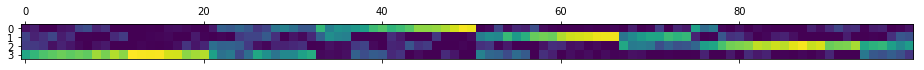

In [9]:
plt.matshow(true_ind_admix_propn.T)

In [10]:
g_obs = data_utils.draw_data(true_pop_allele_freq, true_ind_admix_propn)

In [11]:
g_obs.shape

(100, 2000, 3)

# Get prior

In [12]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [13]:
k_approx = 12

In [14]:
use_logitnormal_sticks = False

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx, use_logitnormal_sticks = False)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (2000, 12, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_beta_params] = NumericArrayPattern (100, 11, 2) (lb=0.0, ub=inf)


## Initialize 

In [15]:
vb_params_dict = structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict, 
                                                        use_logitnormal_sticks)

In [21]:
# take a look at init 
if use_logitnormal_sticks: 
    e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                        vb_params_dict['ind_mix_stick_propn_mean'], 
                        vb_params_dict['ind_mix_stick_propn_info'],
                        gh_loc, gh_weights)

else: 
    # take a look at init 
    ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
    e_stick_lengths = \
            modeling_lib.get_e_beta(ind_mix_stick_beta_params)
    e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])

In [22]:
if k_approx < 6: 
    # find minimizing permutation 
    # only feasible if k_approx is small, 
    # else my computer freezes
    perm = data_utils.find_min_perm(e_pop_freq, true_pop_allele_freq, axis = 1)
else: 
    perm = np.arange(k_approx)
    
e_pop_freq = e_pop_freq[:, perm]
e_ind_admix = e_ind_admix[:, perm]

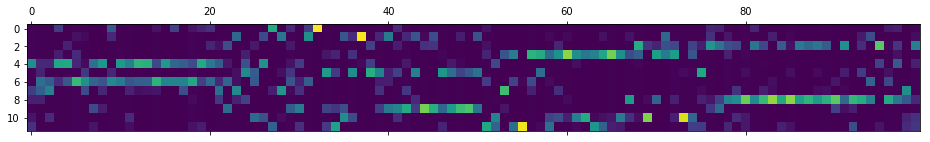

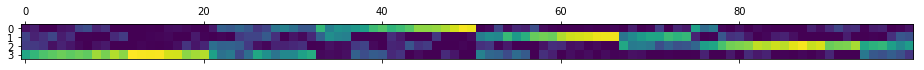

In [23]:
plt.matshow(e_ind_admix.T); 
plt.matshow(true_ind_admix_propn.T);

# Run CAVI

In [19]:
e_log_sticks, e_log_1m_sticks, \
    e_log_pop_freq, e_log_1m_pop_freq = \
        structure_model_lib.get_moments_from_vb_params_dict(g_obs, vb_params_dict, use_logitnormal_sticks)

In [20]:
e_z, stick_beta_params, pop_beta_params = \
    cavi_lib.run_cavi(g_obs, e_log_pop_freq, e_log_1m_pop_freq,
                e_log_sticks, e_log_1m_sticks,
                prior_params_dict)

iteration [0]; kl:302943.263535
iteration [1]; kl:272594.282519
iteration [2]; kl:268274.50017
iteration [3]; kl:266725.579267
iteration [4]; kl:265767.599497
iteration [5]; kl:265051.033037
iteration [6]; kl:264476.714116
iteration [7]; kl:263997.619747
iteration [8]; kl:263586.30296
iteration [9]; kl:263225.496685
iteration [10]; kl:262903.838612
iteration [11]; kl:262613.551809
iteration [12]; kl:262349.106328
iteration [13]; kl:262106.421627
iteration [14]; kl:261882.380035
iteration [15]; kl:261674.52396
iteration [16]; kl:261480.863729
iteration [17]; kl:261299.752988
iteration [18]; kl:261129.805765
iteration [19]; kl:260969.839467
iteration [20]; kl:260818.83424
iteration [21]; kl:260675.902987
iteration [22]; kl:260540.268863
iteration [23]; kl:260411.248411
iteration [24]; kl:260288.238881
iteration [25]; kl:260170.708148
iteration [26]; kl:260058.185647
iteration [27]; kl:259950.253471
iteration [28]; kl:259846.537961
iteration [29]; kl:259746.702997
iteration [30]; kl:25965

KeyboardInterrupt: 

In [ ]:
# check results after CAVI steps

In [ ]:
vb_params_dict['pop_freq_beta_params'] = pop_beta_params
vb_params_dict['ind_mix_stick_beta_params'] = stick_beta_params

In [ ]:
e_pop_allele_freq = modeling_lib.get_e_beta(pop_beta_params)

In [ ]:
if k_approx < 6: 
    perm_best = data_utils.find_min_perm(e_pop_allele_freq, true_pop_allele_freq, axis = 1)
else: 
    perm_best = perm

In [ ]:
ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
e_stick_lengths = \
        modeling_lib.get_e_beta(ind_mix_stick_beta_params)
e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)[:, perm_best]

In [ ]:
plt.matshow(e_ind_admix.T); 
plt.matshow(true_ind_admix_propn.T);

In [ ]:
np.mean(e_ind_admix.argmax(axis=1) == \
       true_ind_admix_propn.argmax(axis=1))